In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

### Utility methods

In [16]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

### Start receipt processing and edge extraction

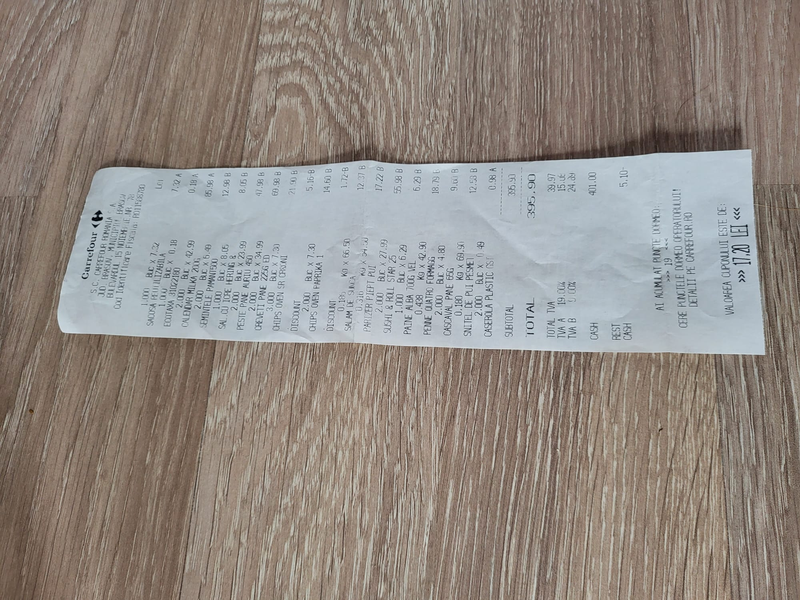

In [17]:
# Sample file out of the dataset
file_name = 'Z:/projects/Receipt-OCR/data/easy_test2.jpeg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.LANCZOS)
img

### Step 1 process the image 
* downscale
* convert to grayscale
* eliminate noise with gaussian blur 
* extract edges with canny edge 

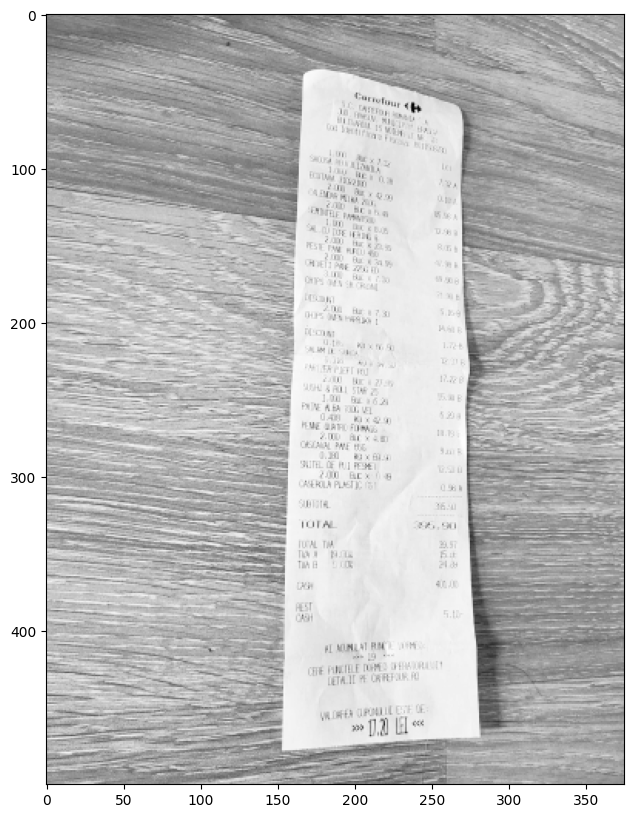

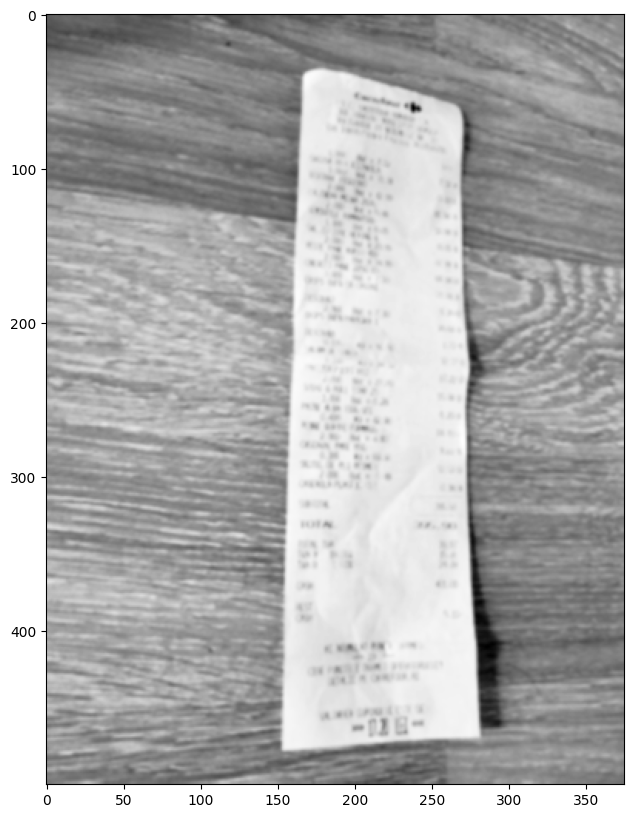

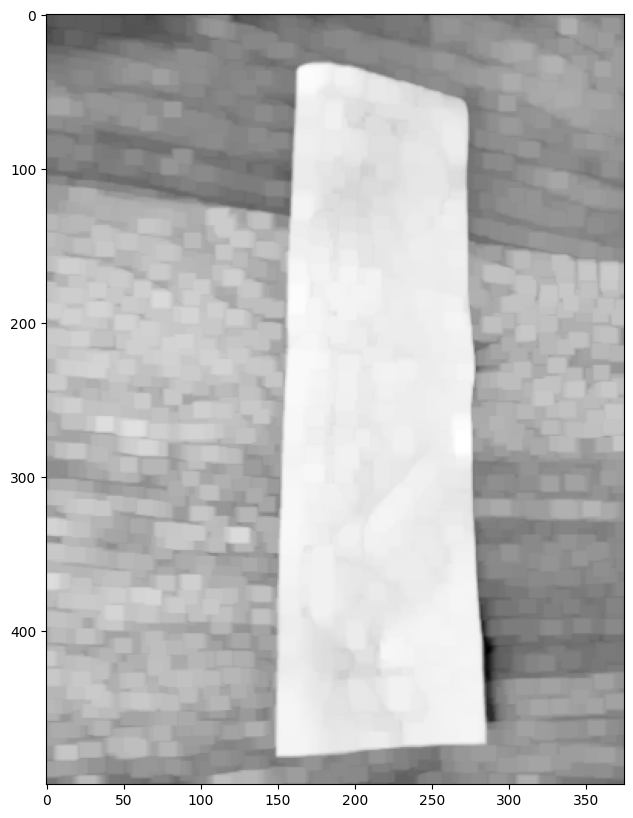

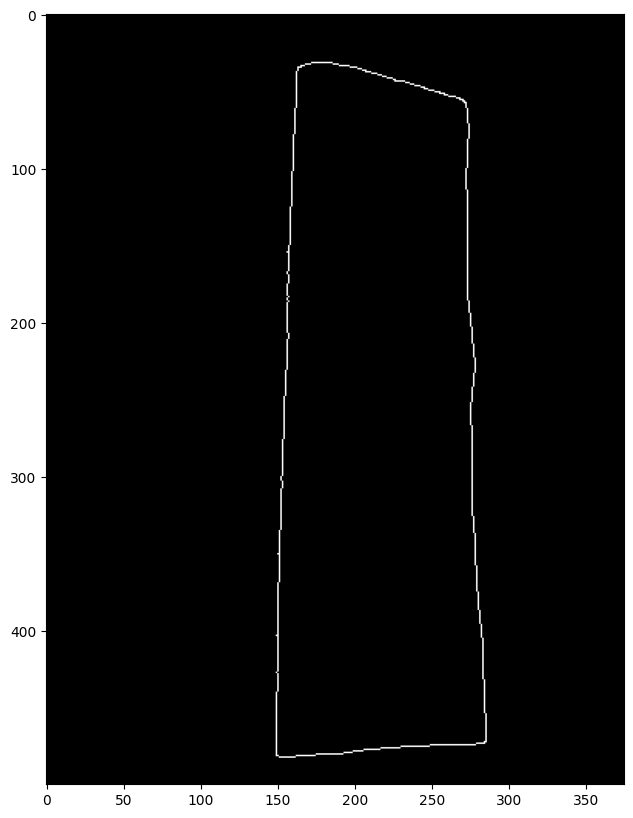

In [18]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

### Detect Countours from the edges

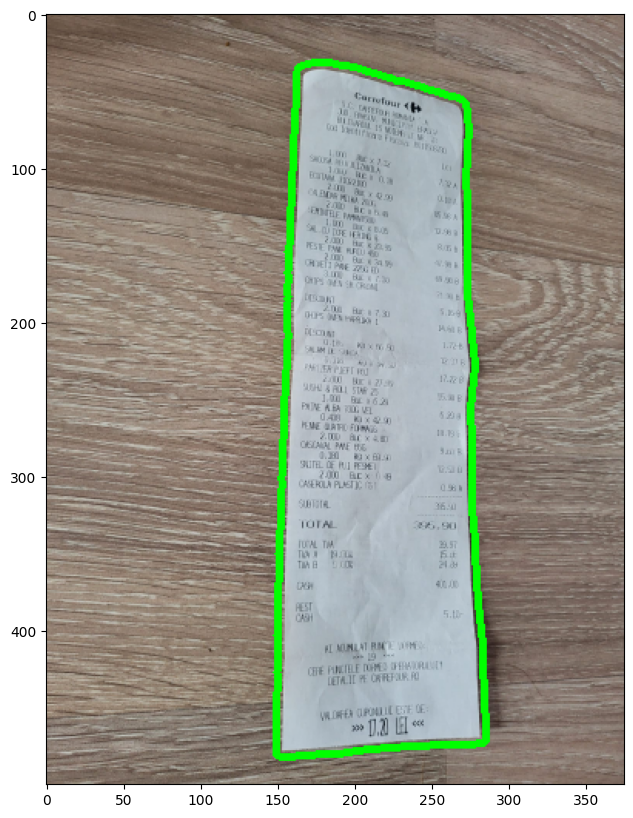

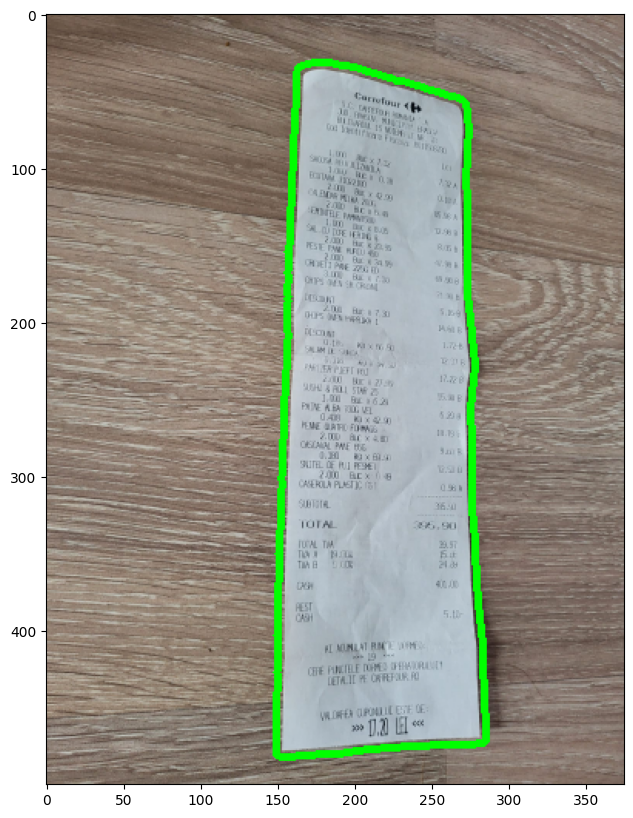

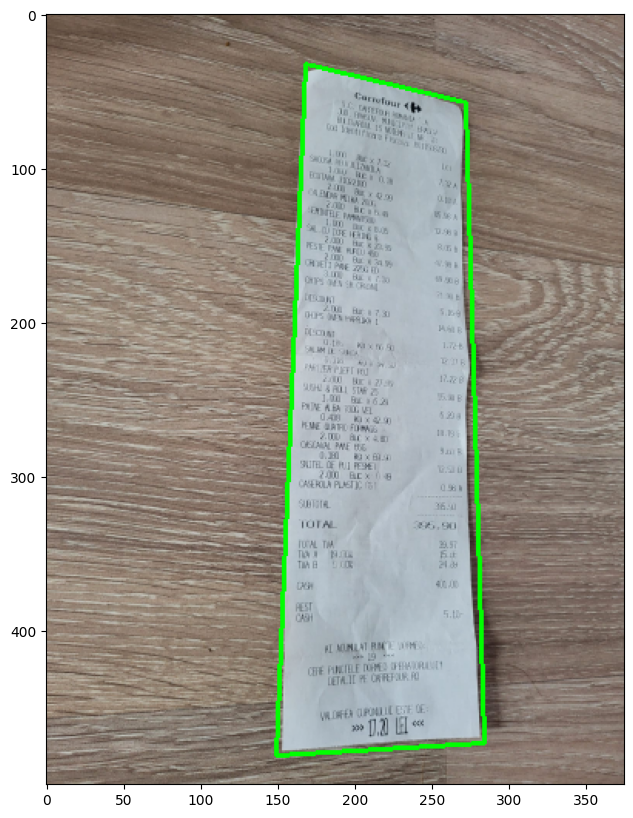

In [19]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx
        
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

### Contour to rectangle and extract receipt

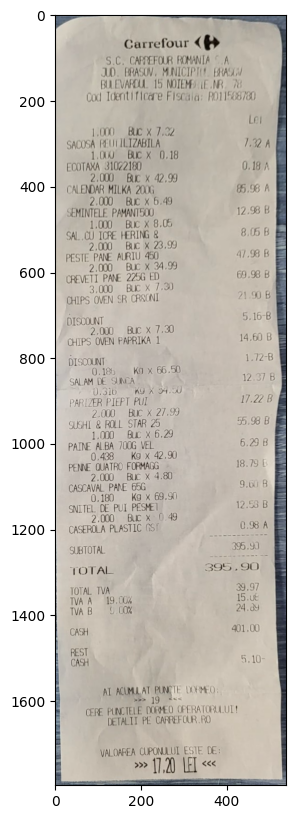

In [20]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio


def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [21]:
type(scanned)

numpy.ndarray

In [22]:
from paddleocr import PaddleOCR
from PIL import Image

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def draw_text_on_blank_side_by_side(
        image_path,
        ocr_result,
        output_path=None,
        show=True,
        font_scale=0.8,
        font_thickness=1):
    """
    Create a blank image of same size and draw extracted text at the box locations.
    Display original and annotated side by side.

    Args:
        image_path: Path or numpy array of the input image.
        ocr_result: OCR result in PaddleOCR format.
        output_path: Optional path to save side-by-side result.
        show: Whether to show the image.
        font_scale: Font size for text drawing.
        font_thickness: Font thickness for text drawing.
    """

    # Load image
    if isinstance(image_path, str):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = image_path

    h, w, _ = img.shape
    blank_img = np.ones_like(img) * 255  # white image

    text_color = (0, 0, 0)  # black

    for line in ocr_result[0]:
        box = np.array(line[0], dtype=np.int32)
        text = line[1][0]

        # Get bottom-left corner of the text
        x = int(np.min(box[:, 0]))
        y = int(np.min(box[:, 1]))

        # Draw the text on the blank image
        cv2.putText(
            blank_img,
            text,
            (x, y),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            text_color,
            font_thickness,
            cv2.LINE_AA
        )

    # Concatenate original and text-drawn image side by side
    side_by_side = np.concatenate((img, blank_img), axis=1)

    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(side_by_side, cv2.COLOR_RGB2BGR))

    if show:
        plt.figure(figsize=(16, 10))
        plt.imshow(side_by_side)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


[2025/04/17 22:02:32] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\test/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\test/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', r

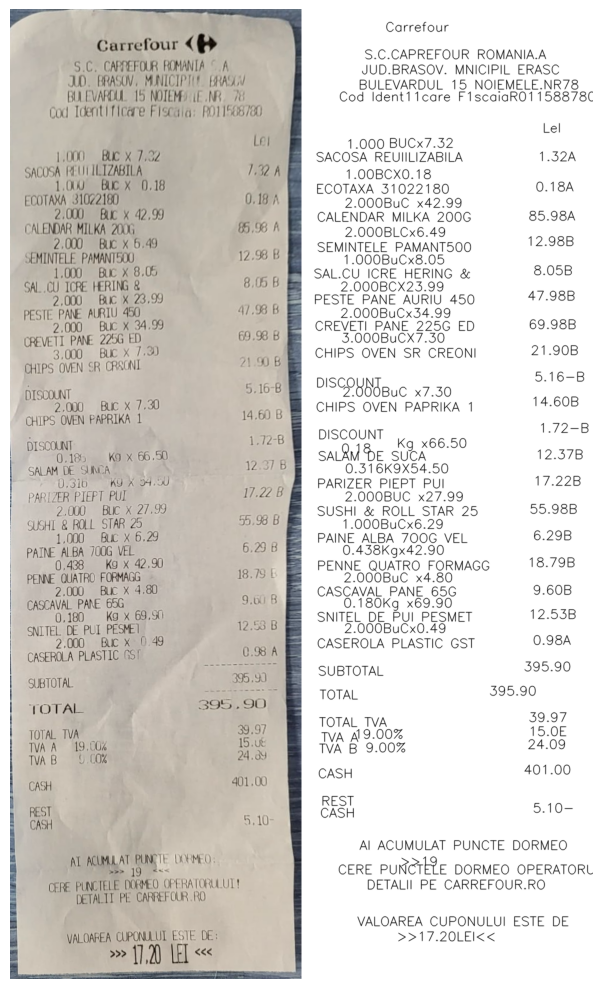

In [24]:
ocr = PaddleOCR(
    use_angle_cls=True,
    lang='en',
    use_gpu=True)

result = ocr.ocr(scanned, cls=True)
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line)

# draw result
boxes = [line[0] for line in result[0]]
txts = [line[1][0] for line in result[0]]

draw_text_on_blank_side_by_side(
    image_path=scanned,
    ocr_result=result,
    show=True,
)


In [25]:
result[0]

[[[[155.0, 45.0], [384.0, 41.0], [385.0, 80.0], [156.0, 84.0]],
  ('Carrefour', 0.9922168254852295)],
 [[[116.0, 92.0], [407.0, 92.0], [407.0, 118.0], [116.0, 118.0]],
  ('S.C.CAPREFOUR ROMANIA.A', 0.9221401810646057)],
 [[[111.0, 120.0], [435.0, 120.0], [435.0, 144.0], [111.0, 144.0]],
  ('JUD.BRASOV. MNICIPIL ERASC', 0.8078451156616211)],
 [[[105.0, 148.0], [435.0, 148.0], [435.0, 174.0], [105.0, 174.0]],
  ('BULEVARDUL 15 NOIEMELE.NR78', 0.8869686722755432)],
 [[[69.0, 174.0], [470.0, 170.0], [471.0, 202.0], [70.0, 206.0]],
  ('Cod Ident11care F1scaiaR011588780', 0.8165929913520813)],
 [[[446.0, 228.0], [488.0, 228.0], [488.0, 258.0], [446.0, 258.0]],
  ('Lel', 0.7595739960670471)],
 [[[82.0, 258.0], [174.0, 258.0], [174.0, 285.0], [82.0, 285.0]],
  ('1.000', 0.9866836667060852)],
 [[[161.0, 256.0], [278.0, 256.0], [278.0, 283.0], [161.0, 283.0]],
  ('BUCx7.32', 0.8184472322463989)],
 [[[26.0, 288.0], [247.0, 282.0], [248.0, 309.0], [27.0, 315.0]],
  ('SACOSA REUIILIZABILA', 0.91123

## Generate the json using regex ? (we could write regex rules for different types of receipts but this might be retarded tbh)

In [26]:
import re
import json

def average_y(bbox):
    return sum(pt[1] for pt in bbox) / 4

def sort_ocr_lines(ocr_data):
    return sorted(ocr_data, key=lambda entry: average_y(entry[0]))

def extract_line_data(text):
    patterns = {
        "quantity_unit": re.compile(r'(?P<quantity>\d+(\.\d+)?)(?:BuC|BUCX|BC|BLC)?\s*x\s*(?P<unit_price>\d+\.\d{2})', re.IGNORECASE),
        "total_price": re.compile(r'(?P<total_price>\d+\.\d{2})([A-B-])?'),
    }
    match_quantity = patterns["quantity_unit"].search(text)
    match_total = patterns["total_price"].search(text)

    quantity = float(match_quantity.group("quantity")) if match_quantity else None
    unit_price = float(match_quantity.group("unit_price")) if match_quantity else None
    total_price = float(match_total.group("total_price")) if match_total else None

    return {
        "text": text,
        "quantity": quantity,
        "unit_price": unit_price,
        "total_price": total_price
    }

def build_items_from_ocr(ocr_data):
    sorted_lines = sort_ocr_lines(ocr_data)
    items = []
    current_item = {}

    for _, (text, confidence) in sorted_lines:
        line_info = extract_line_data(text)

        if not current_item.get("name") and not line_info["quantity"] and not line_info["total_price"]:
            current_item["name"] = text

        elif line_info["quantity"] and line_info["unit_price"]:
            current_item["quantity"] = line_info["quantity"]
            current_item["unit_price"] = line_info["unit_price"]

        elif line_info["total_price"]:
            current_item["total_price"] = line_info["total_price"]
            if current_item.get("name"):
                items.append(current_item)
            current_item = {}

    return items


In [27]:
parsed_items = build_items_from_ocr(result[0])

# Print it nicely
print(json.dumps(parsed_items, indent=2))

[
  {
    "name": "Carrefour",
    "total_price": 7.32
  },
  {
    "name": "SACOSA REUIILIZABILA",
    "quantity": 1.0,
    "unit_price": 0.18,
    "total_price": 0.18
  },
  {
    "name": "ECOTAXA 31022180",
    "quantity": 2.0,
    "unit_price": 42.99,
    "total_price": 85.98
  },
  {
    "name": "CALENDAR MILKA 200G",
    "quantity": 2.0,
    "unit_price": 6.49,
    "total_price": 12.98
  },
  {
    "name": "SEMINTELE PAMANT500",
    "quantity": 1.0,
    "unit_price": 8.05,
    "total_price": 8.05
  },
  {
    "name": "SAL.CU ICRE HERING &",
    "quantity": 2.0,
    "unit_price": 23.99,
    "total_price": 47.98
  },
  {
    "name": "PESTE PANE AURIU 450",
    "quantity": 2.0,
    "unit_price": 34.99,
    "total_price": 69.98
  },
  {
    "name": "CREVETI PANE 225G ED",
    "quantity": 3.0,
    "unit_price": 7.3,
    "total_price": 21.9
  },
  {
    "name": "CHIPS OVEN SR CREONI",
    "total_price": 5.16
  },
  {
    "name": "DISCOUNT",
    "quantity": 2.0,
    "unit_price": 7.3,
 

## Use some llms to extract the json from the ocr output

In [28]:
import torch

ModuleNotFoundError: No module named 'torch'

In [26]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Choose a model - T5-base works reasonably well for text-to-text tasks,
# but you might consider others or even a fine-tuned variant for extraction.
model_name = "t5-small"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

ocr_output_str = json.dumps(result[0], indent=2)

# Create an instruction-driven prompt including the OCR output string
prompt = f"""
You are given OCR output from a receipt where each entry consists of a bounding box and a tuple (text, confidence).
Extract each valid item from the receipt and produce a JSON array.
For each item, create an object with the following keys:
  - "description": The text from OCR.
  - "price": The price on that line (if available).
  - "quantity": The number of units (assume 1 if not specified).
  - "total_price": The total price (if not given, assume equal to price * quantity).
Return only valid JSON.

OCR output:
{ocr_output_str}

JSON output:
"""

# Tokenize the prompt text
inputs = tokenizer(prompt, return_tensors="pt")

# Generate the output (you might need to adjust max_length and decoding parameters)
outputs = model.generate(**inputs, max_length=1024, num_beams=5, early_stopping=True)
result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("*"*20)
print(result_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (5511 > 512). Running this sequence through the model will result in indexing errors


********************
from a receipt where each entry consists of a bounding box and a tuple (text, confidence). Extract each item from the receipt and produce a JSON array. Extract each item from the receipt and produce a JSON array. Each item consists of a bounding box and a tuple (text, confidence). Extract each item from the receipt and produce a JSON array. Each item consists of a bounding box and a tuple (


In [25]:
import json
from transformers import AutoTokenizer, AutoModelForCausalLM


# Convert the Python list to a JSON formatted string
ocr_output_str = json.dumps(result[0], indent=2)

# Create an instruction-driven prompt including the OCR output string
prompt = f"""
You are given OCR output from a receipt where each entry consists of a bounding box and a tuple (text, confidence).
Extract each valid item from the receipt and produce a JSON array.
For each item, create an object with the following keys:
  - "description": The text from OCR.
  - "price": The price on that line (if available).
  - "quantity": The number of units (assume 1 if not specified).
  - "total_price": The total price (if not given, assume equal to price * quantity).
Return only valid JSON.

OCR output:
{ocr_output_str}

JSON output:
"""

# Specify the LLaMA-7B model repository
acces_token = "--"
model_name = "meta-llama/Llama-2-7b-chat-hf"

# Load the tokenizer and model. Note: trust_remote_code=True is required for this model.
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, token=acces_token)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, token=acces_token)

# Encode the prompt
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Generate the output; adjust parameters as needed
outputs = model.generate(
    input_ids=input_ids,
    max_length=1024,
    do_sample=True,
    temperature=0.7,
    num_return_sequences=1,
)

# Decode the generated text
result_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated JSON output:")
print(result_text)

ImportError: 
LlamaTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.
